In [1]:
import numpy as np
from scipy.special import xlogy

# Define activation functions

In [2]:
# Normalization is used to avoid overflows in softmax
softmax = lambda x: np.exp( x - (np.ones(np.shape(x))*x.max(axis=1)[:,np.newaxis]) ) / np.exp( x-(np.ones(np.shape(x))*x.max(axis=1)[:,np.newaxis]) ).sum(axis=1)[:,np.newaxis]
relU = lambda x: np.maximum(0,x)


# Define Neural Network

In [3]:
class NeuralNetwork():
    
    def __init__(self, inputs, hidden, outputs):
        """
        Initialize neural network with a single hidden layer.
        
        Args:
            inputs: int, input dimension
            hidden: int, number of hidden neurons
            outputs: int, number of output neurons
        Returns:
            None
        """
        
        # Initialize the weights (and biases) of the neural network
        
        # W is the weights connecting the inputs to the hidden layer
        # Initialized from random unifrom distribution from -1 to 1
        self.W = 2*np.random.rand(inputs+1, hidden)-1 # inputs +1 for the bias
        
        # V is the weights connecting the hidden layer to the outputs
        # Initialized from random uniform distribution from -1 to 1
        self.V = 2*np.random.rand(hidden,outputs)-1
        
        
    def loss(self, y_true, y_pred):
        """
        Compute categorical cross-entropy loss. 
        
        Sum loss contributions over the outputs (axis=1), later 
        loss is averaged over the examples (axis=0)
        
        Args: 
            y_true: NxD numpy array with N examples, D outputs (one-hot labels).
            y_pred: NxD numpy array with N examples, D outputs (probabilities).
        Returns:
            loss: array of length N representing loss for each example.
        """
        return -1.0*np.sum( xlogy(y_true,y_pred), axis=1 )
        
    def evaluate(self, X, y):
        """
        Make predictions and compute loss.
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            loss: array of length N representing loss for each example.
        """
        # calculate y predictions given X
        y_calc = self.predict(X)
                
        return self.loss(y_true=y, y_pred=y_calc)
        
    def predict(self, X):
        """
        Make predictions on inputs X.
        Args:
            X: NxM numpy array where n-th row is an input.
        Returns: 
            y_pred: NxD array where n-th row is vector of probabilities.
        """        
        # Add 1 to the end of each input for bias 
        X = np.concatenate( ( X, np.ones( (len(X),1) ) ), axis=1 )
                
        # Calculate the hidden layer
        H = relU( np.dot(X,self.W) )
                        
        # Calculate output
        y_pred = softmax( np.dot(H, self.V) )
        
        return y_pred
        
    def train(self, X, y, lr=0.0001, max_steps=10, x_val=None, y_val=None, batch_size=10):
        """
        Train the neural network using mini-batch stochastic gradient descent.
        
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
            lr: scalar learning rate. Use small value for debugging.
            max_steps: int, number of gradient descent steps.
            x_val: numpy array containing validation data inputs.
            y_val: numpy array containing validation data outputs.
        Returns:
            history: dict with the following key, value pairs:
                     'loss' -> list containing the training loss at each epoch
                     'loss_val' -> list for the validation loss at each epoch
        """
        # Lists to store history of loss and loss_val
        loss = []
        loss_val = []
                
        for i in range(max_steps):
                                
            # Obtain random small batch from training data
            indxs = np.random.randint(0,len(X),size=batch_size)
            X_rand = np.concatenate( ( X[indxs,:], np.ones( (len(X[indxs,:]),1) ) ), axis=1 ) # add 1 to inputs for bias
            y_rand = y[indxs,:]
            
            # Make prediction on random batch
            y_pred = softmax( np.dot( relU( np.dot( X_rand, self.W ) ),self.V ) )
            
            # Calculate \partial L \partial z
            dLdz = y_pred-y_rand
            
            # Compute hidden layer
            h = relU(np.dot(X_rand,self.W))
            
            # Calculate \partial L \partial V
            dLdV = np.dot(h.T,dLdz)
            
            # Calculate \partial L \partial z_hidden
            dLdz_h = np.dot( dLdz, np.transpose( self.V ) )
            dLdz_h[h < 0] = 0 # This adds the partial derivative of relU to the chain rule
            
            # Calculate \partial L \partial W
            dLdW = np.dot(X_rand.T,dLdz_h)
                        
            # Update weights 
            self.W -= lr*dLdW
            self.V -= lr*dLdV
                                    
            # Store Loss history, average over the examples (axis=0)
            loss += [ np.mean( self.evaluate(X,y) ) ]
            loss_val += [ np.mean( self.evaluate(x_val,y_val) ) ]
            
        return loss, loss_val
                

# Download Fashion MNIST Dataset

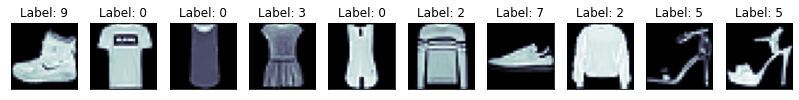

In [4]:
import gzip
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [5]:
# Record how many features there are
feats = np.shape(train_images)[1]

print("Training shape: ",np.shape(train_images))
print("Testing shape: ",np.shape(test_images))

Training shape:  (60000, 784)
Testing shape:  (10000, 784)


# Train and test the NN

In [6]:
# Initialize Neural Network
NN = NeuralNetwork(inputs = feats, hidden = 100, outputs = 10)

# Train the NN, record the losses
loss, loss_val = NN.train(X=train_images, y=train_labels, lr=0.001, max_steps=1000, x_val=test_images, y_val=test_labels,  batch_size =100)
       


Text(0, 0.5, 'Loss')

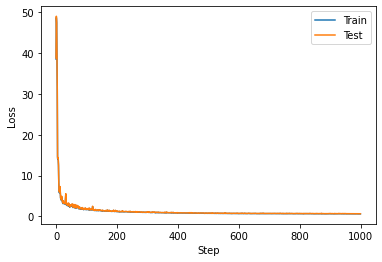

In [14]:
# Plot the losses for the best NN
plt.plot(np.arange(len(loss)),loss,label="Train")
plt.plot(np.arange(len(loss_val)),loss_val,label="Test")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")


Because this is a simple model and we have a lot of data (10k examples), overfitting was not an issue and early stopping was not needed.

In [8]:
# Compute test accuracy
Correct = 0
for x,y in zip(NN.predict(test_images),test_labels):
    # Simple way to check if prediction is right
    if np.argmax(x) == np.argmax(y):
        Correct += 1
        
print("Model Test Accuracy: ", 1.0*Correct/len(test_labels))

Model Test Accuracy:  0.782


# Visualize the 10 test examples with the largest loss.

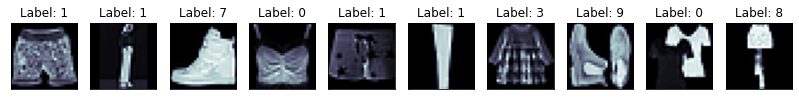

In [9]:
# Compute loss for test images
test_losses = NN.evaluate(test_images,test_labels)

# Sort images and labels with respect to loss
sort_ind = test_losses.argsort()
sorted_images = test_images[sort_ind]
sorted_y = test_labels[sort_ind]

# Keep only the images and labels with the top 10 loss
top10 = sorted_images[ len(sorted_images)-10 : len(sorted_images) ]
top10_y = sorted_y[ len(sorted_y)-10 : len(sorted_y) ]

# plot the images
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(top10[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {top10_y[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

# Demonstrating overfitting on a small training set

In [10]:
# Take smaller sample so that it is easier to overfit
small_train_images = train_images[0:500]
small_train_labels = train_labels[0:500]

# Create the Neural Network object with 100 neurons
NN_OF = NeuralNetwork(inputs = feats, hidden = 100, outputs = 10)

# Train NN_OF on the small sample of training images and labels
print("Training Neural Network...")
print("Training Examples: ", np.shape(small_train_images)[0])
print("Test Examples: ", np.shape(test_images)[0])
loss_OF, loss_val_OF = NN_OF.train(X=small_train_images, y=small_train_labels, lr=0.001, max_steps=1000, x_val=test_images, y_val=test_labels,  batch_size =100)


Training Neural Network...
Training Examples:  500
Test Examples:  10000


Text(0, 0.5, 'Loss')

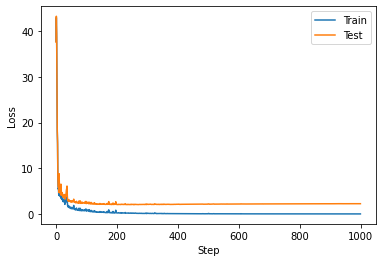

In [11]:
# Plot the Train and Test Loss versus Epoch to demonstrate overfitting in the network
plt.plot(np.arange(len(loss_OF)),loss_OF,label="Train")
plt.plot(np.arange(len(loss_val_OF)),loss_val_OF,label="Test")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")


The Test Loss is increasing while the training loss is decreasing - overfitting.


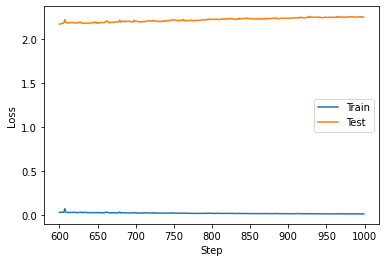

In [12]:
# Zoom into later end of plot to confirm overfitting
plt.plot(np.arange(len(loss_OF[600:1000]))+600,loss_OF[600:1000],label="Train")
plt.plot(np.arange(len(loss_val_OF[600:1000]))+600,loss_val_OF[600:1000],label="Test")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")

print("The Test Loss is increasing while the training loss is decreasing - overfitting.")